In [1]:
%ls

Data/                           Topic_Modeling_YunpengLi.ipynb
EDA (1).ipynb                   Wrangling.ipynb
EDA_Updated.ipynb               clustering_jorge.ipynb
Images/                         helper_functions.py
LICENSE                         references/
README.md


In [2]:
try:
    from google.colab import drive

    drive.mount('./drive/')

    %cd drive/My \ Drive/Text_Summarization

except:
    print("No Colab Environment")

No Colab Environment


In [3]:
import json
import pandas as pd
import numpy as np
import re
import seaborn as sns

# Load Data

In [4]:
df_overview = pd.read_csv("./Data/processed/LongForm_Clean_Lemma_Telehealth.csv")
df_overview.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content,Content_Length,Abstract_Length,Parsed_Keywords,Parsed_Keywords_Length,Subfield,et_al_Count,LongForm,LongForm_Clean_Content,LongForm_Clean_Content_length,LongForm_Clean_Content_Lemma,Classification
0,Psychological Services,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...,37477,2411,"['telepsychology,', 'meta-analysis,', 'veteran...",5,Clinical & Counseling Psychology,50,Veterans face a variety of stressors related t...,Veterans face a variety of stressors related t...,43903,veteran face a variety of stressor relate time...,Covid
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...,74025,1577,"['remote', 'child', 'custody', 'evaluations,',...",10,Forensic Psychology,48,The impact of the coronavirus disease 2019 pan...,The impact of the coronavirus disease 2019 pan...,90181,the impact of the coronavirus disease 2019 pan...,Covid
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig...",63568,1842,"['forensic', 'e-mental', 'health,', 'telehealt...",8,Forensic Psychology,128,"In November 2019, coronavirus disease 2019—the...",In November 2019 coronavirus disease 2019—the ...,72051,in November 2019 coronavirus disease 2019 — th...,Covid
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...,30147,1650,"['education', 'and', 'training,', 'telepsychol...",6,Clinical & Counseling Psychology,21,Anxiety and depressive disorders are among the...,Anxiety and depressive disorders are among the...,35085,anxiety and depressive disorder be among the m...,Covid
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the...",42367,1871,"['remote', 'psychotherapy,', 'Covid-19,', 'pan...",6,Clinical & Counseling Psychology,14,"In mid-March, 2020, the authors—as well as the...",In mid-March 2020 the authors—as well as the m...,48376,in mid - March 2020 the author — as well as th...,Covid


## Pre and Post Covid Dataset

In [5]:
df_precovid = df_overview[df_overview["Classification"] == "Pre-Covid"]
df_covid = df_overview[df_overview["Classification"] == "Covid"]

## EDA

In [6]:
import matplotlib
import matplotlib.pyplot as plt

from yellowbrick.text import FreqDistVisualizer, TSNEVisualizer, DispersionPlot, PosTagVisualizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

matplotlib.rcParams["figure.figsize"] = (20, 7)

/Users/adamgoldstein/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


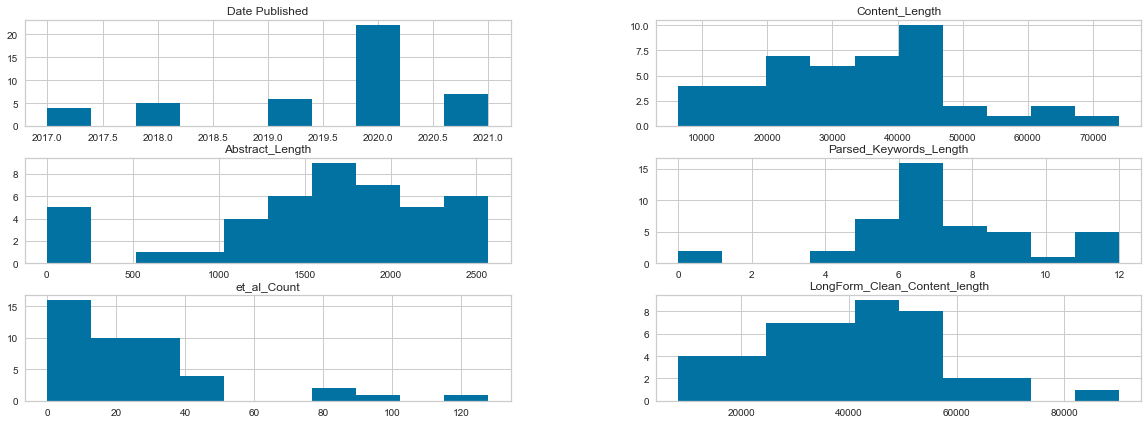

In [7]:
_ = df_overview.hist()

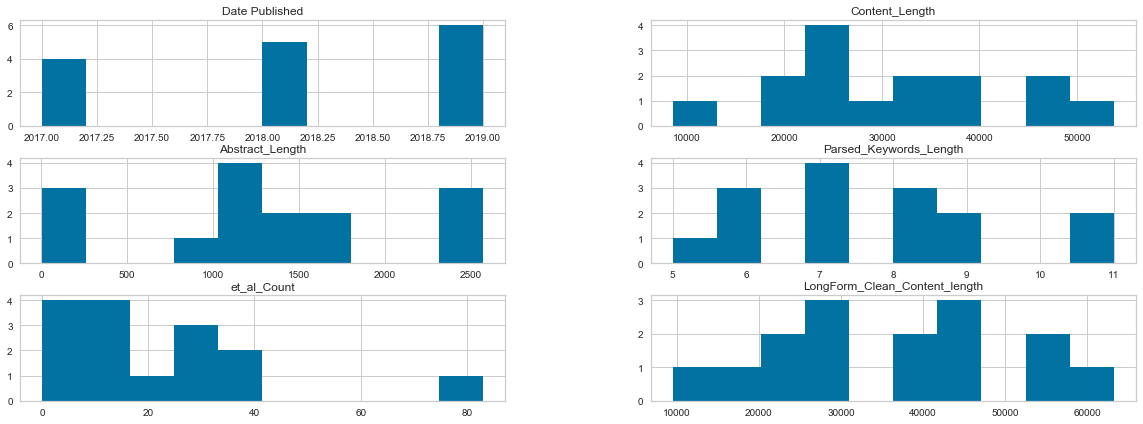

In [8]:
_ = df_precovid.hist()

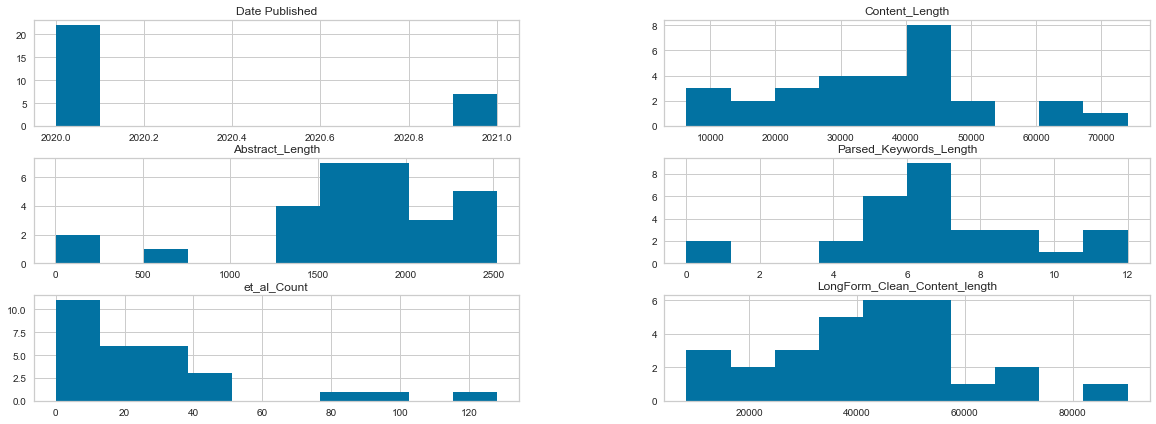

In [9]:
_ = df_covid.hist()

In [10]:
datasets = [df_overview,df_covid,df_precovid]
dataset_labels = ["Overview","During Covid","Pre-Covid"]

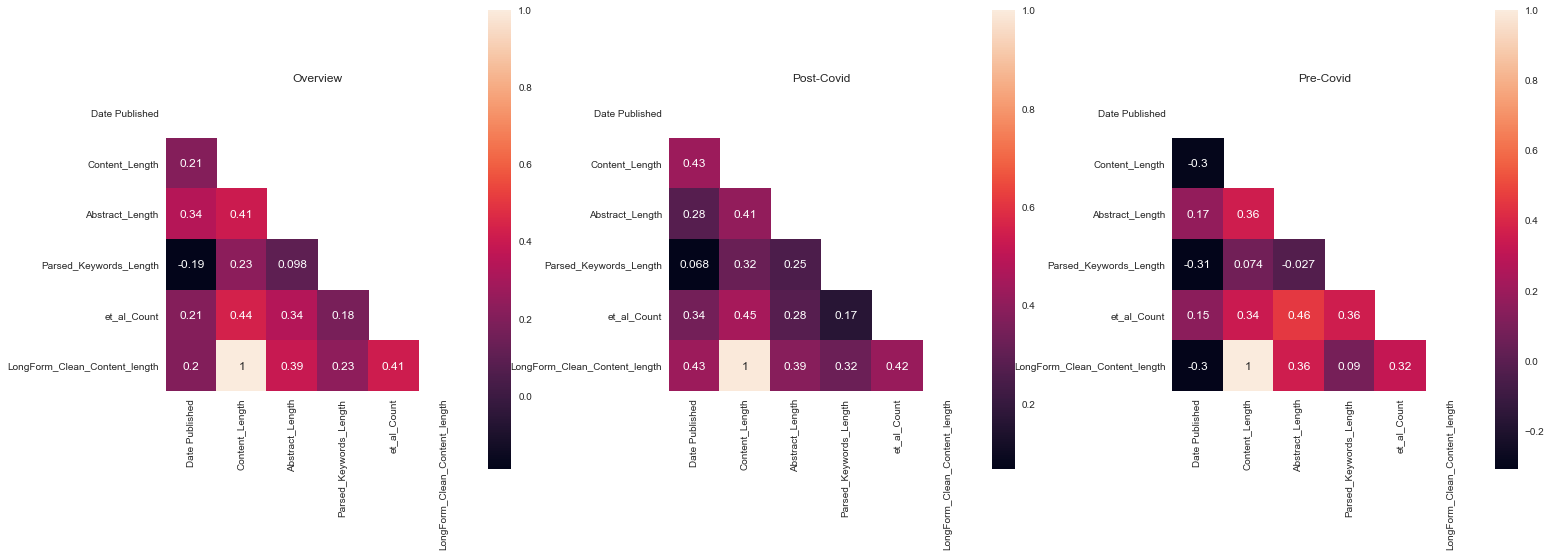

In [11]:
# There are not strong linear correlations between the lengths or Date Published

fig, ax = plt.subplots(1,3)

fig.tight_layout(h_pad=2,w_pad=8)

# datasets = [df_metadata,df_metadata_post_covid,df_metadata_pre_covid]
dataset_labels = ["Overview","Post-Covid","Pre-Covid"]

for index, dataset in enumerate(datasets):

    corr = dataset.corr()

    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(corr,ax=ax[index], annot=True,square=True,mask=mask)
    ax[index].set_title(f"{dataset_labels[index]}")


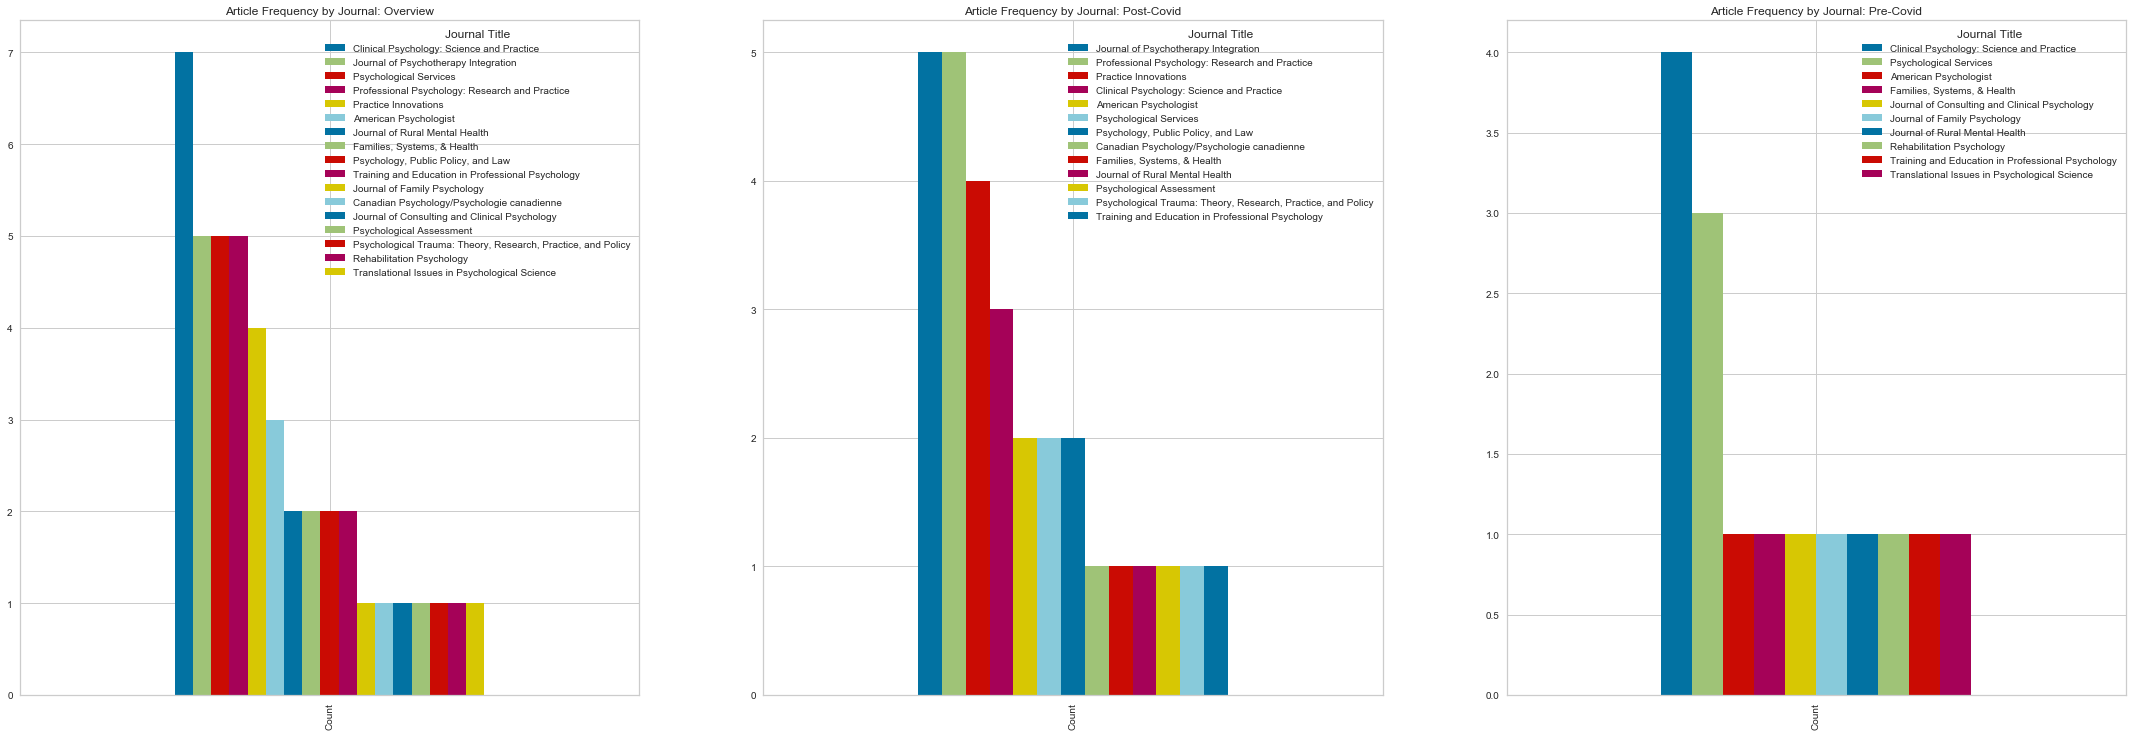

In [12]:
fig, ax = plt.subplots(1,3,figsize=(30,10))

fig.tight_layout(h_pad=2,w_pad=8)


for index, dataset in enumerate(datasets):

    dataset[["Journal Title","Content"]].rename(columns={"Content":"Count"}).groupby("Journal Title").count().sort_values("Count",ascending=False).T.plot(kind="bar"
    ,ax=ax[index]
    ,title=f"Article Frequency by Journal: {dataset_labels[index]}")
    

## Acronyms - Include as Vocabulary for Paper

In [13]:
import spacy

nlp = spacy.load("en_core_web_sm")

corpus = df_overview["LongForm_Clean_Content_Lemma"]

docs = list(nlp.pipe(corpus,disable=["parser","textcat"]))

## NER

In [14]:
ner_dictionary = dict()

ner_dictionary_count = dict()

ner_dictionary_document = dict()

#NER token with label
for index, doc in enumerate(docs):
    
    for ent in doc.ents:

        ner_dictionary[ent.text] = ent.label_

        #ner_dictionary_document[ent.text]  (ent.text,index)

        if ent.text in ner_dictionary_count.keys():
            ner_dictionary_count[ent.text] += 1
            ner_dictionary_document[ent.text].add(str(index))

        else:
            ner_dictionary_count[ent.text] = 0
            ner_dictionary_document[ent.text] = {str(index)}

In [15]:
ner_data = [ner_dictionary,ner_dictionary_count,ner_dictionary_document]

df_ner = (pd.DataFrame(ner_data).T.reset_index()
          .rename(columns={0:"NER_Label",1:"Count","index":"Term",2:"Document"})
          .sort_values("Count",ascending=False))

#df_ner["Term_Long_Form"] = df_ner["Term"].apply(lambda x: abrv_dict[x] if x in abrv_dict.keys() else x)

#df_ner["Document"] = df_ner["Document"].apply(lambda doc: doc)

In [16]:
df_ner.head()

,Term,NER_Label,Count,Document
5,2018,DATE,630,"{20, 37, 25, 41, 30, 8, 16, 17, 36, 5, 28, 15,..."
26,2019,DATE,374,"{37, 30, 8, 5, 28, 15, 12, 31, 22, 35, 10, 14,..."
2604,Telemental,PRODUCT,355,"{32, 37, 27, 31, 38, 41, 36, 35, 40, 33}"
16,Providers,ORG,352,"{37, 25, 41, 30, 8, 16, 17, 36, 5, 28, 15, 42,..."
3,Veterans Affairs,ORG,333,"{42, 29, 2, 12, 36, 27, 18, 38, 41, 16, 0, 35,..."


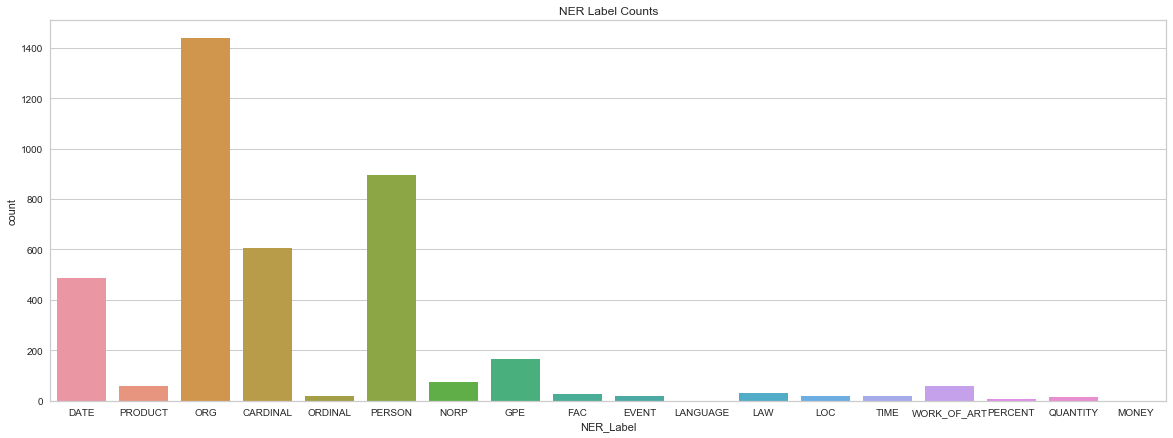

In [17]:
ax = sns.countplot(data=df_ner,x="NER_Label")
_ = ax.set_title("NER Label Counts")

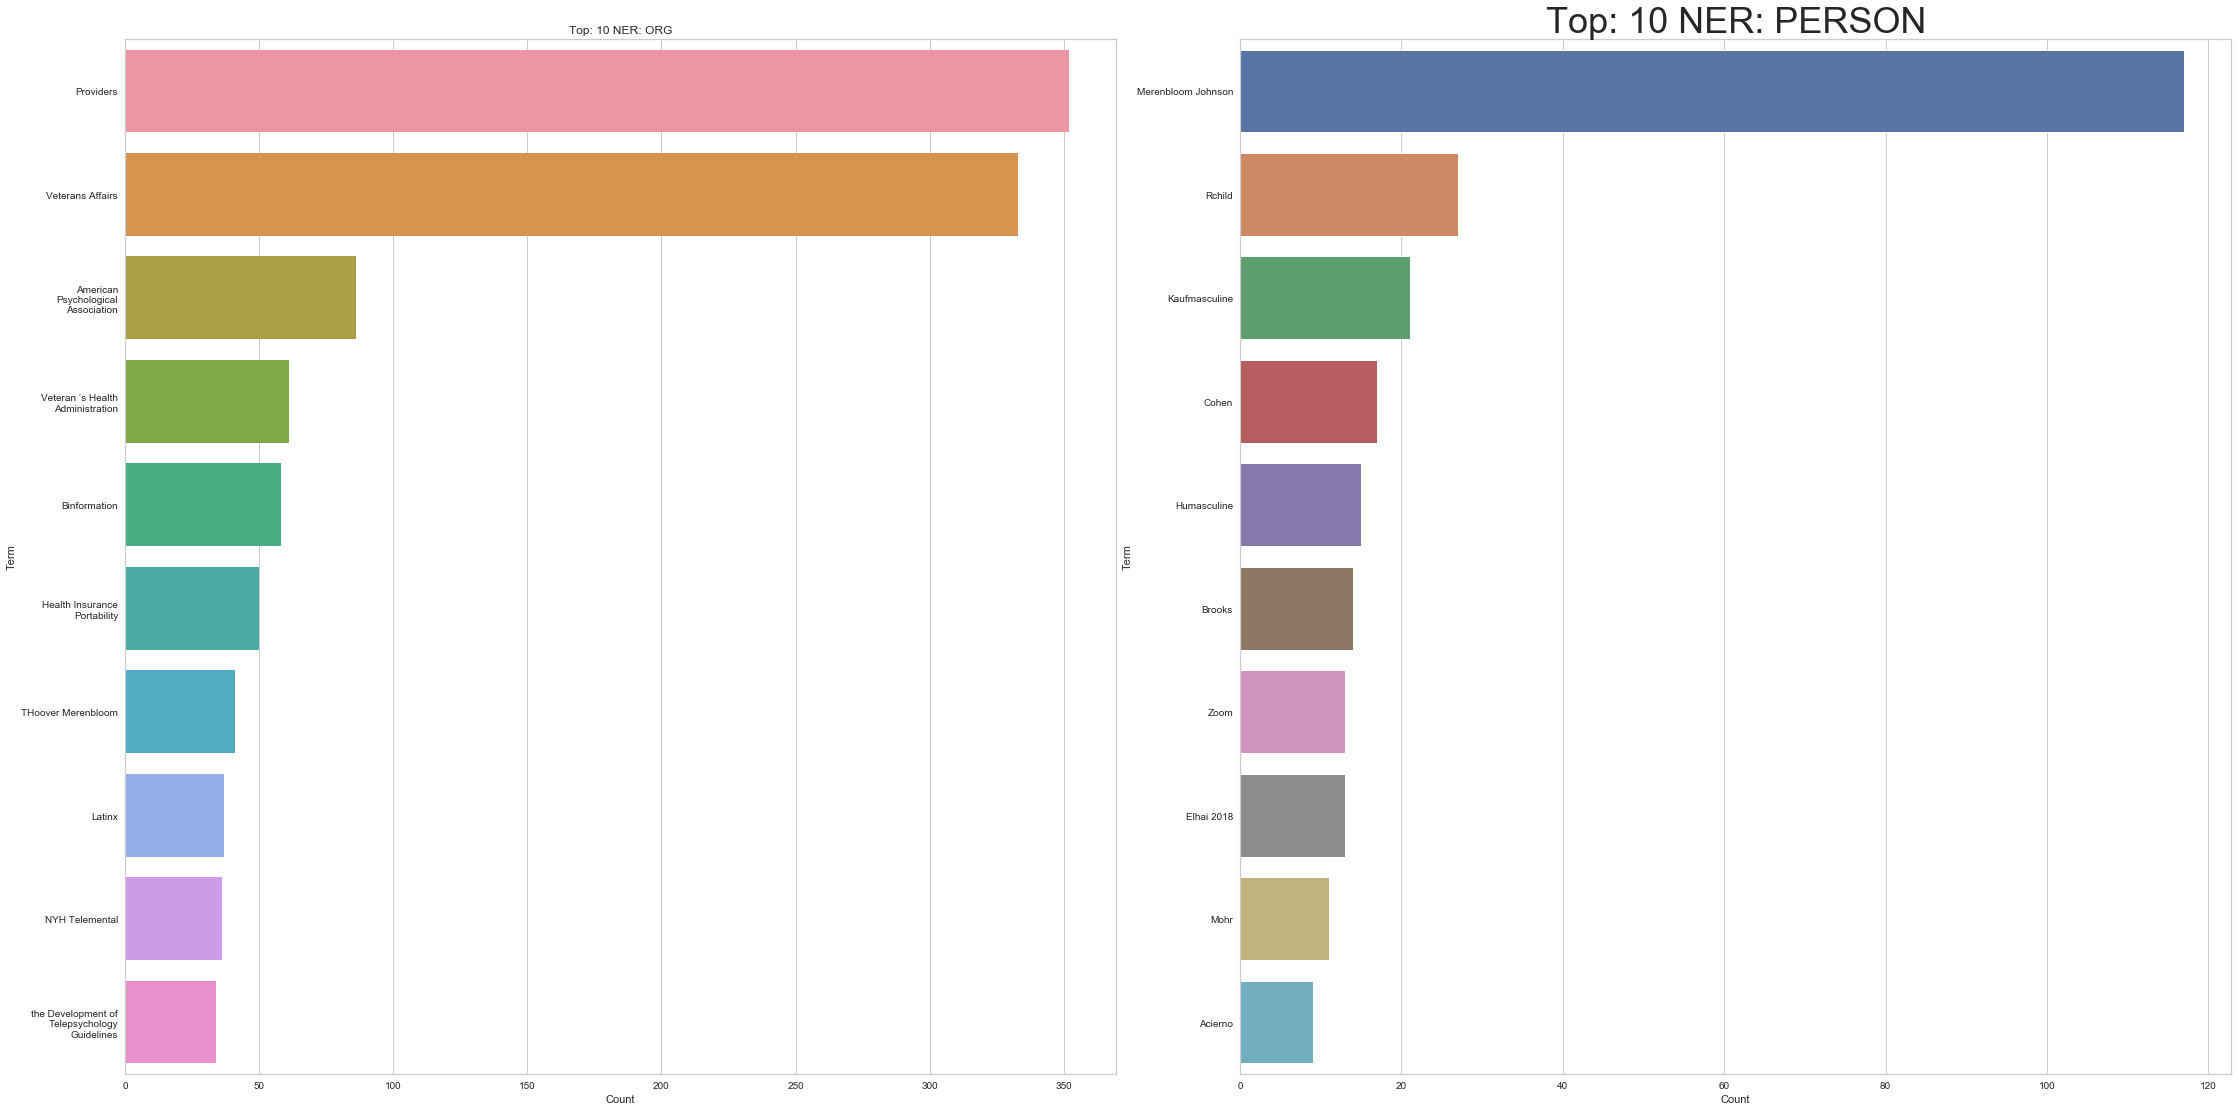

In [18]:
import textwrap

top = 10
visualize_cols = ["ORG","PERSON"]

fig, ax = plt.subplots(1,len(visualize_cols),figsize = (30,15))
fig.tight_layout(h_pad=2,w_pad=8)

for index,col in enumerate(visualize_cols):
    data = df_ner[df_ner["NER_Label"] == col][:10]
    _ = sns.barplot(data=data,x="Count",y="Term",ax=ax[index],orient="h")
    ax[index].set_title(f"Top: {top} NER: {col}")
    _ = sns.set(font_scale = 3)  
    ax[index].set_yticklabels([textwrap.fill(phrase, 21) for phrase in data["Term"].head(top)])

# Text Mining - frequency counts of words, length of sentences, presence/absence of specific words

In [19]:
def countplots(data,dataset_name,vectorizers,cols=4,):

    rows = len(vectorizers)
    cols = cols #dynamically change n_grams and plots

    fig, ax = plt.subplots(rows,cols,figsize=(30,15))
    fig.tight_layout(h_pad=2,w_pad=cols*4)

    for index, vect in enumerate(vectorizers):

        for i in range(cols):

            vectorizer = vect(stop_words=nlp.Defaults.stop_words,ngram_range=(i+1,i+1),lowercase=False)
            vectorizer_name = str(vectorizer)
            vectorizer_title = vectorizer_name[:vectorizer_name.find("(")]
            documents = vectorizer.fit_transform(data)
            features = vectorizer.get_feature_names()
            visualizer = FreqDistVisualizer(features=features, orient="H",n=10,ax=ax[index,i])
            ax[index,i].set_title(f"Dataset: {dataset_name} - {vectorizer_title} {vectorizer.ngram_range}")
            _ = visualizer.fit(documents)
            _ = sns.set(font_scale = 3)  
            #ax[index,i].set_yticklabels([textwrap.fill(phrase, 20) for phrase in data.head(10)])



# Keyword Extraction Based on Count



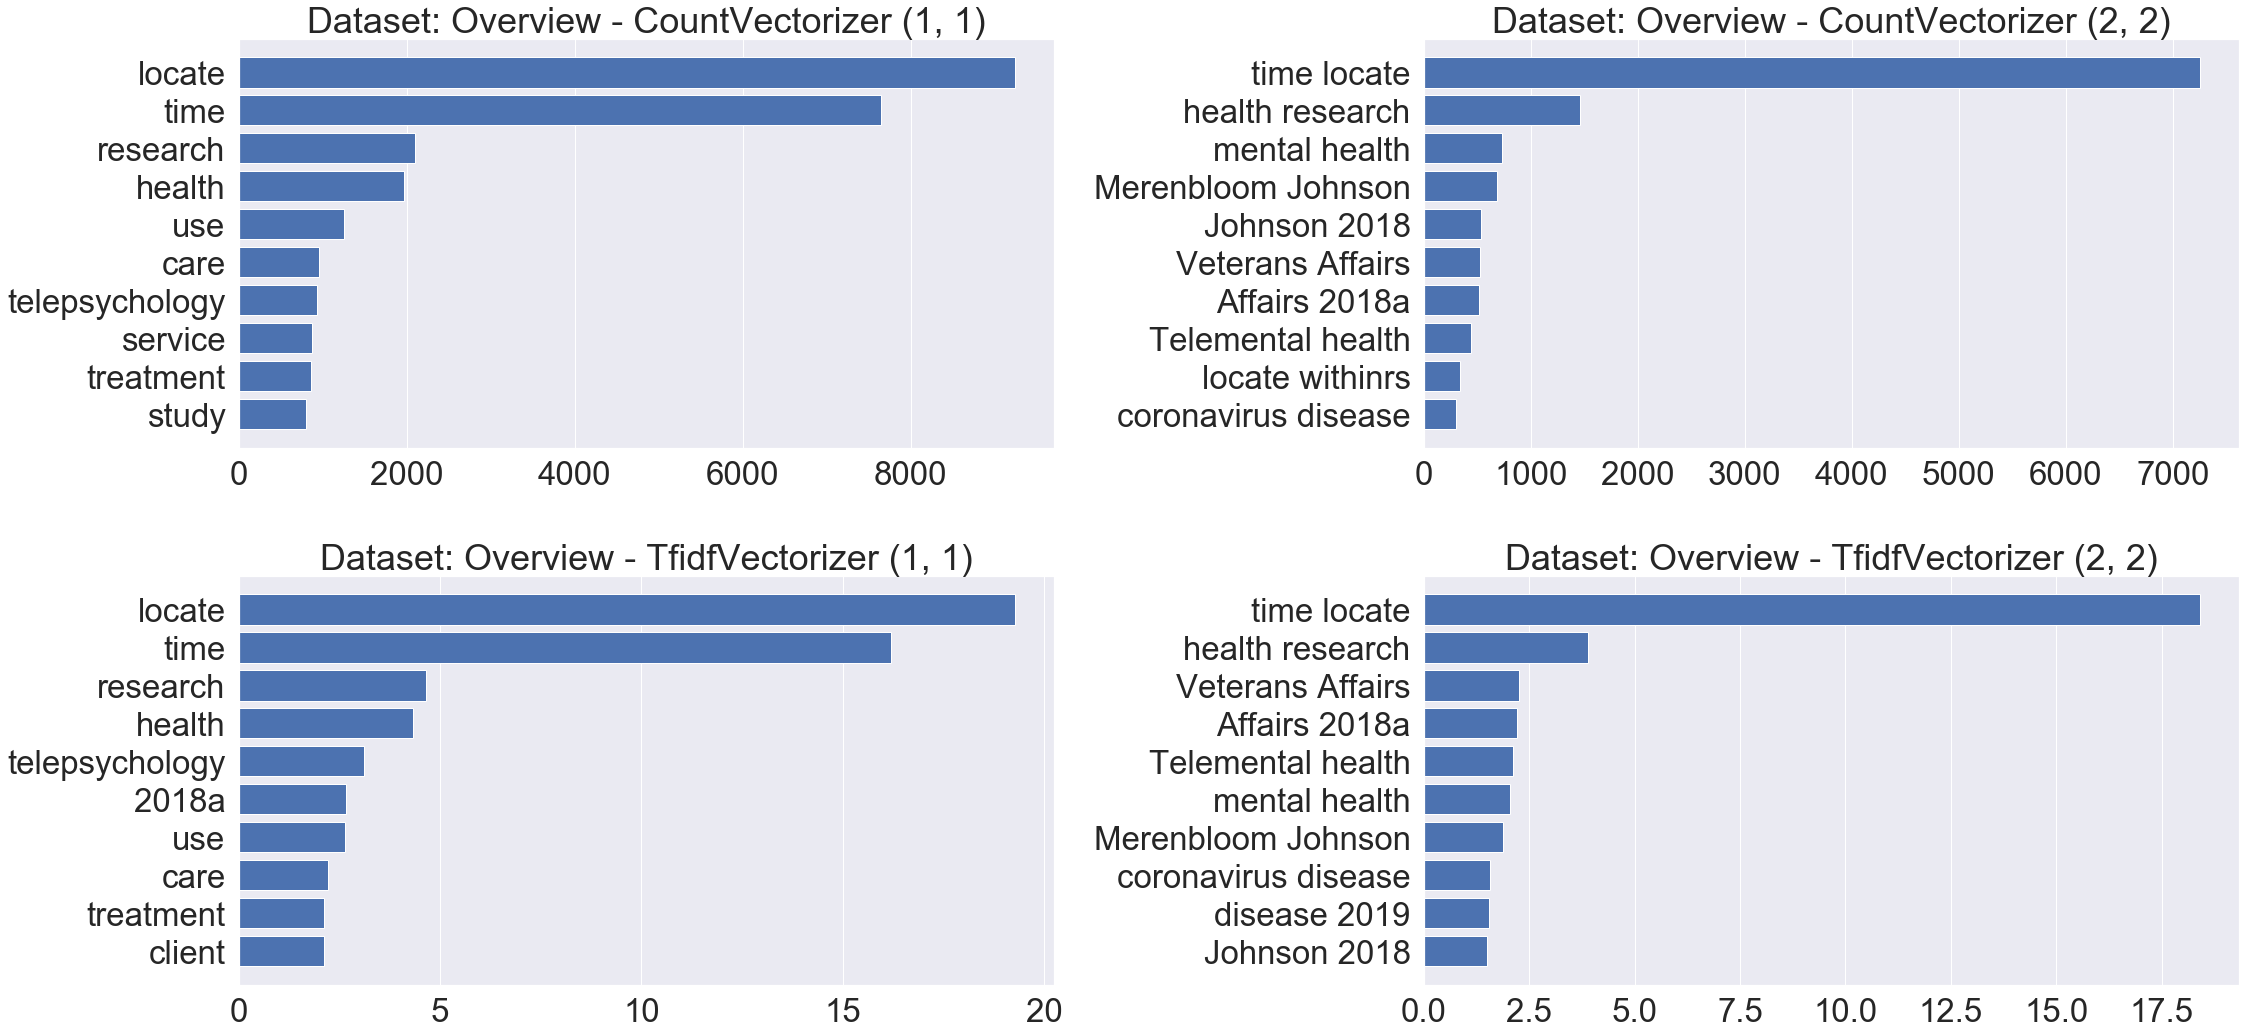

In [20]:
#Add stop words
nlp.Defaults.stop_words |= {"PRON","et","al","ll","ve"}

countplots(df_overview["LongForm_Clean_Content_Lemma"],"Overview",[CountVectorizer,TfidfVectorizer],cols=2)


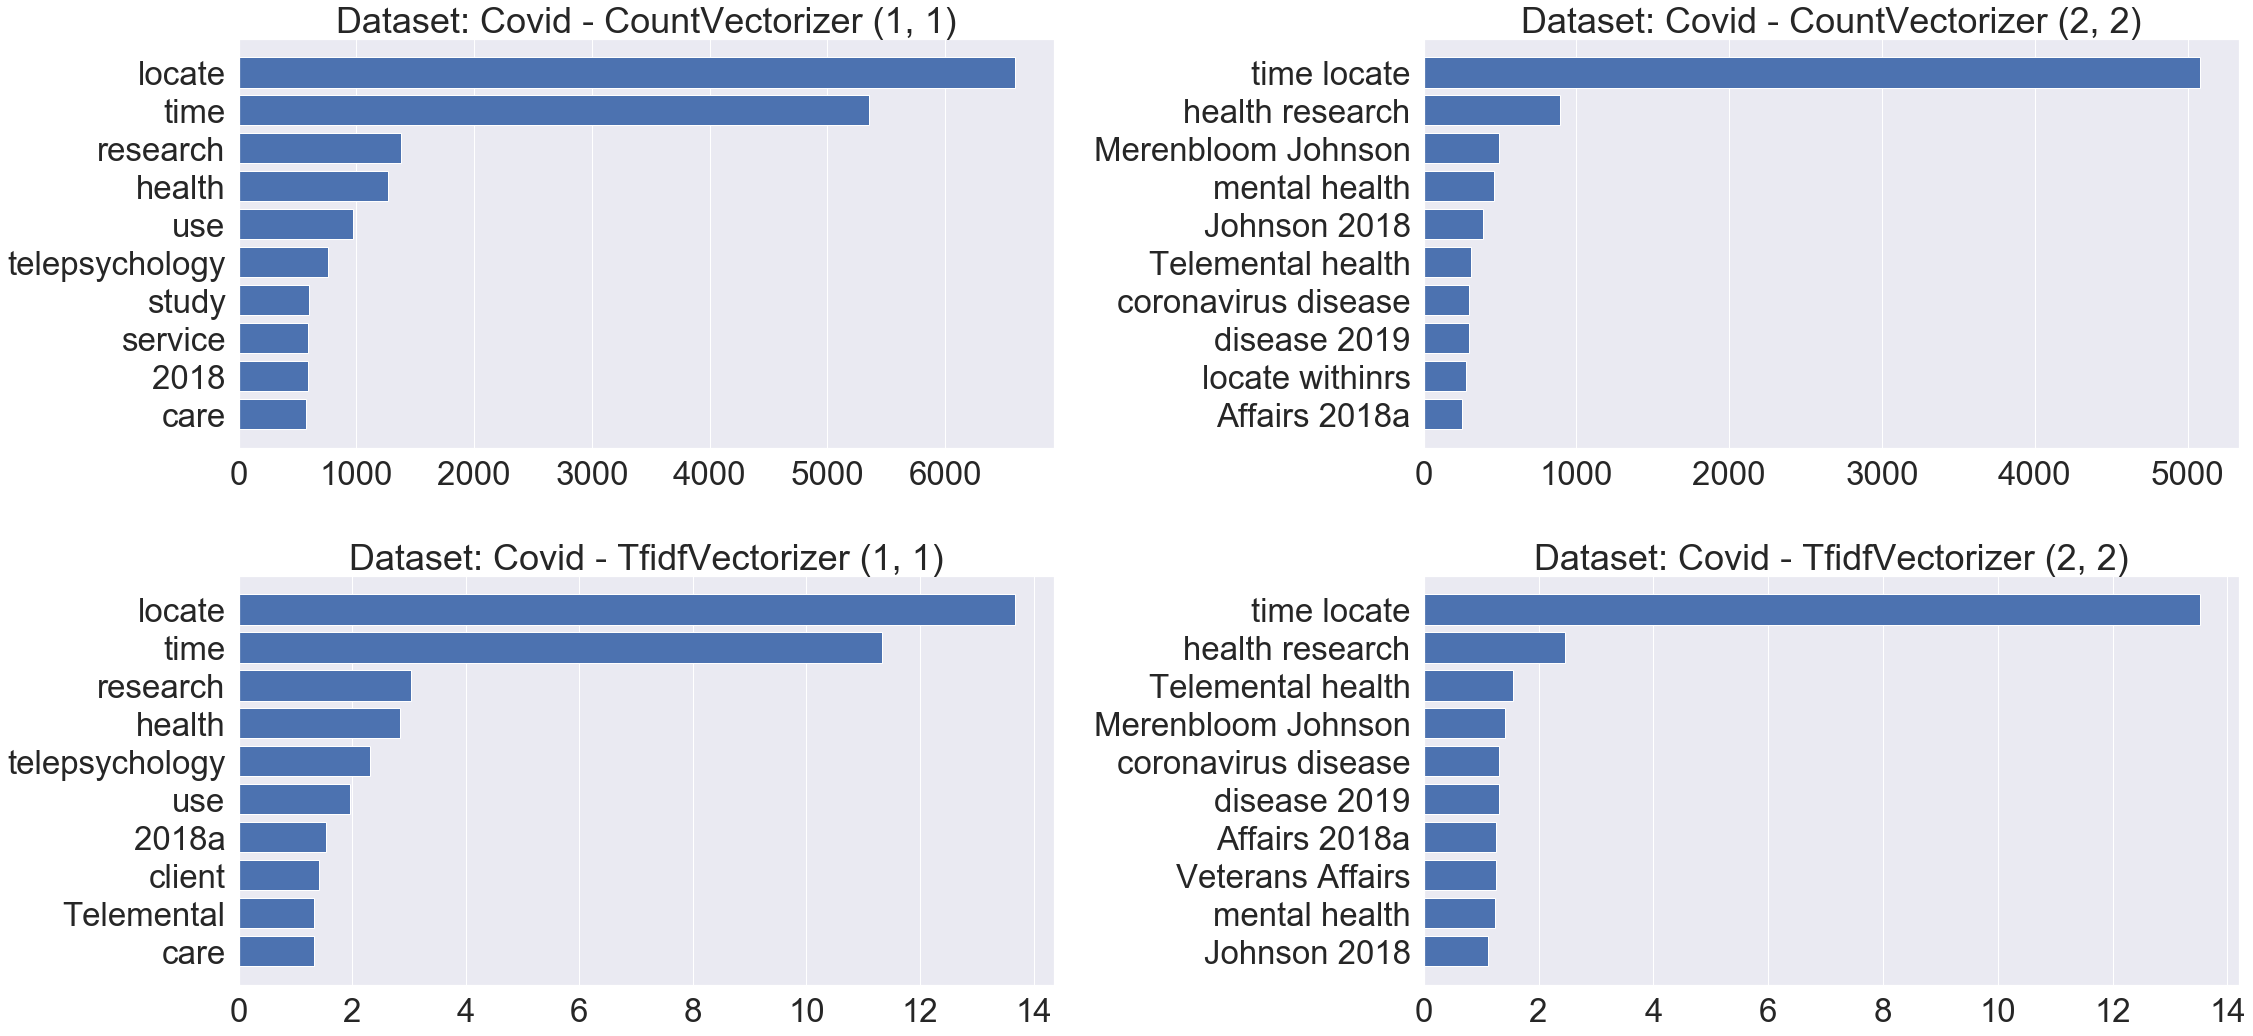

In [21]:
countplots(df_covid["LongForm_Clean_Content_Lemma"],"Covid",[CountVectorizer,TfidfVectorizer],cols=2)


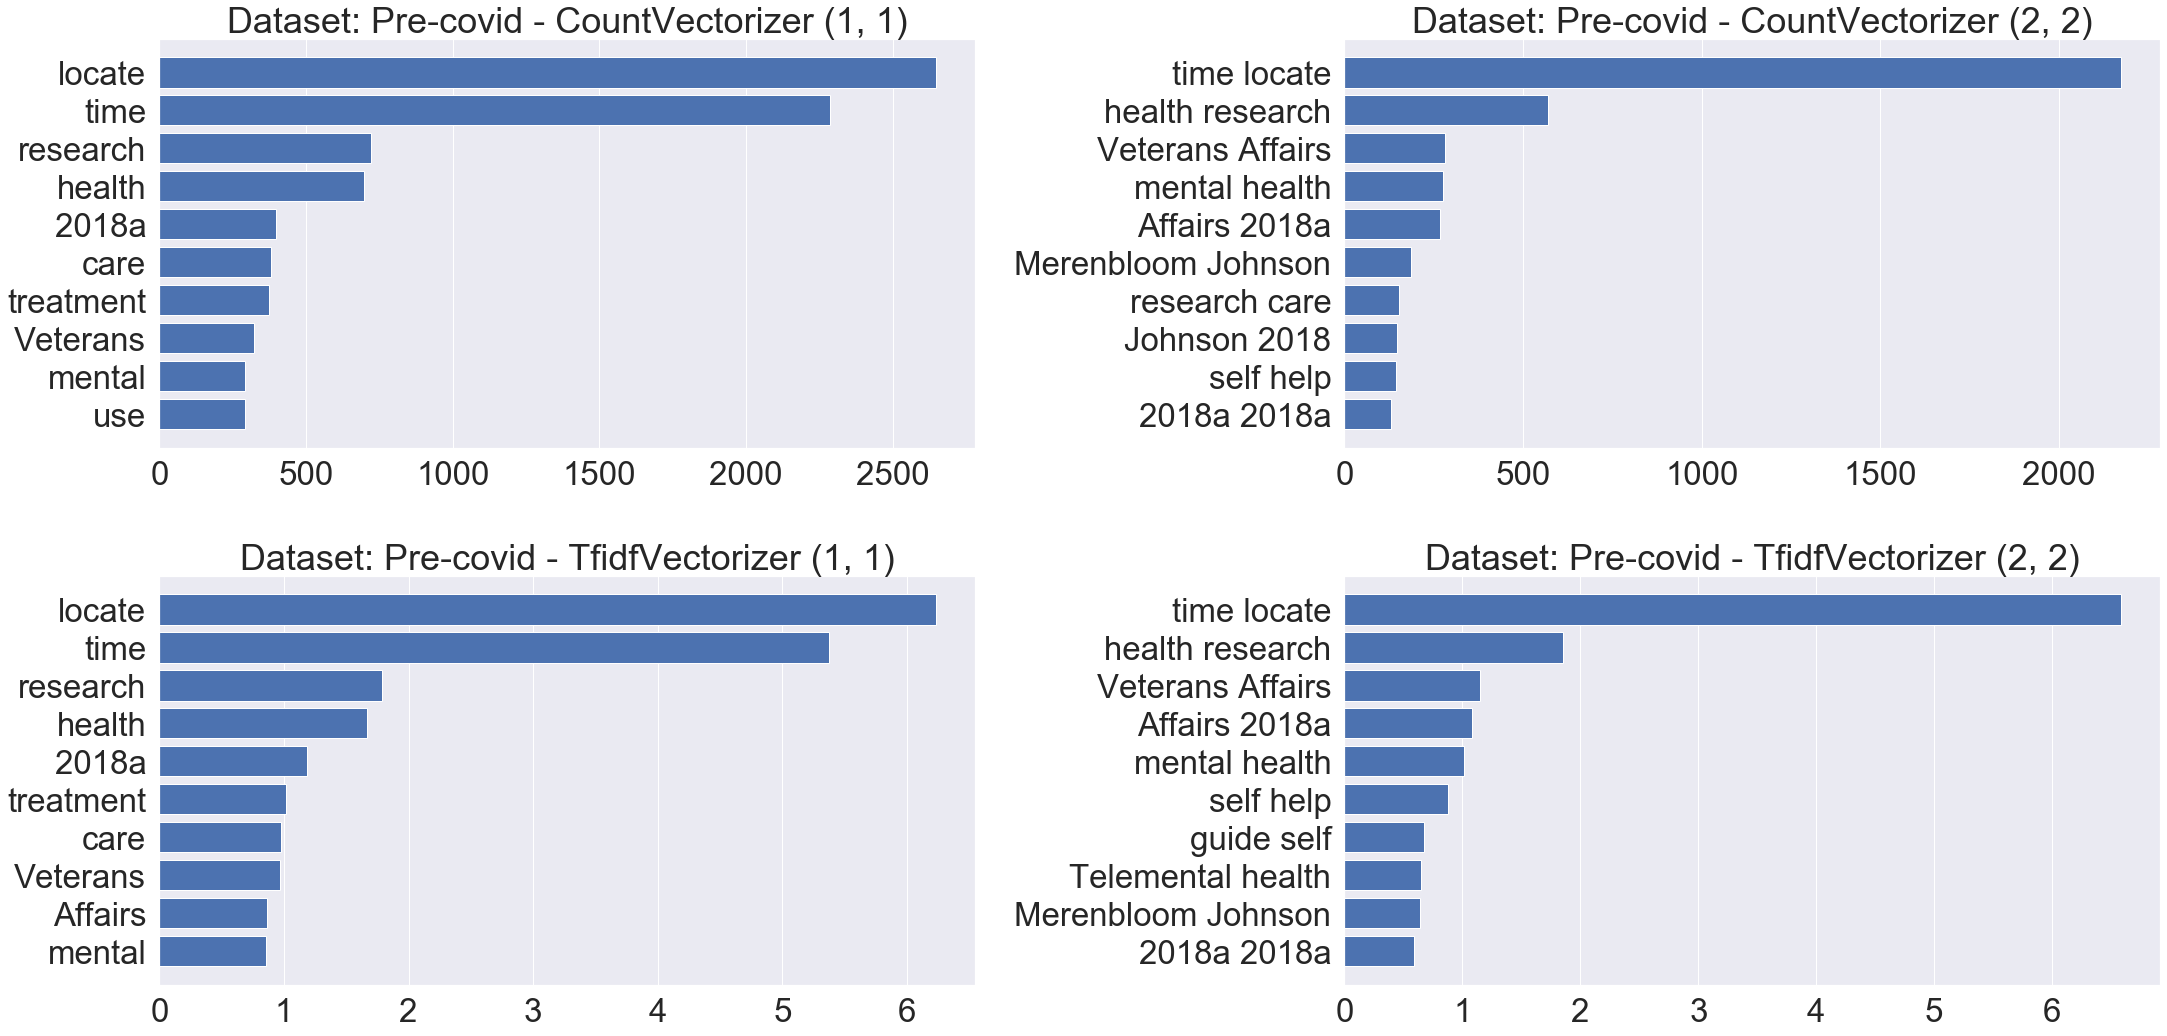

In [22]:
countplots(df_precovid["LongForm_Clean_Content_Lemma"],"Pre-covid",[CountVectorizer,TfidfVectorizer],cols=2)


# Keyword Extraction from Given Dataset - Count

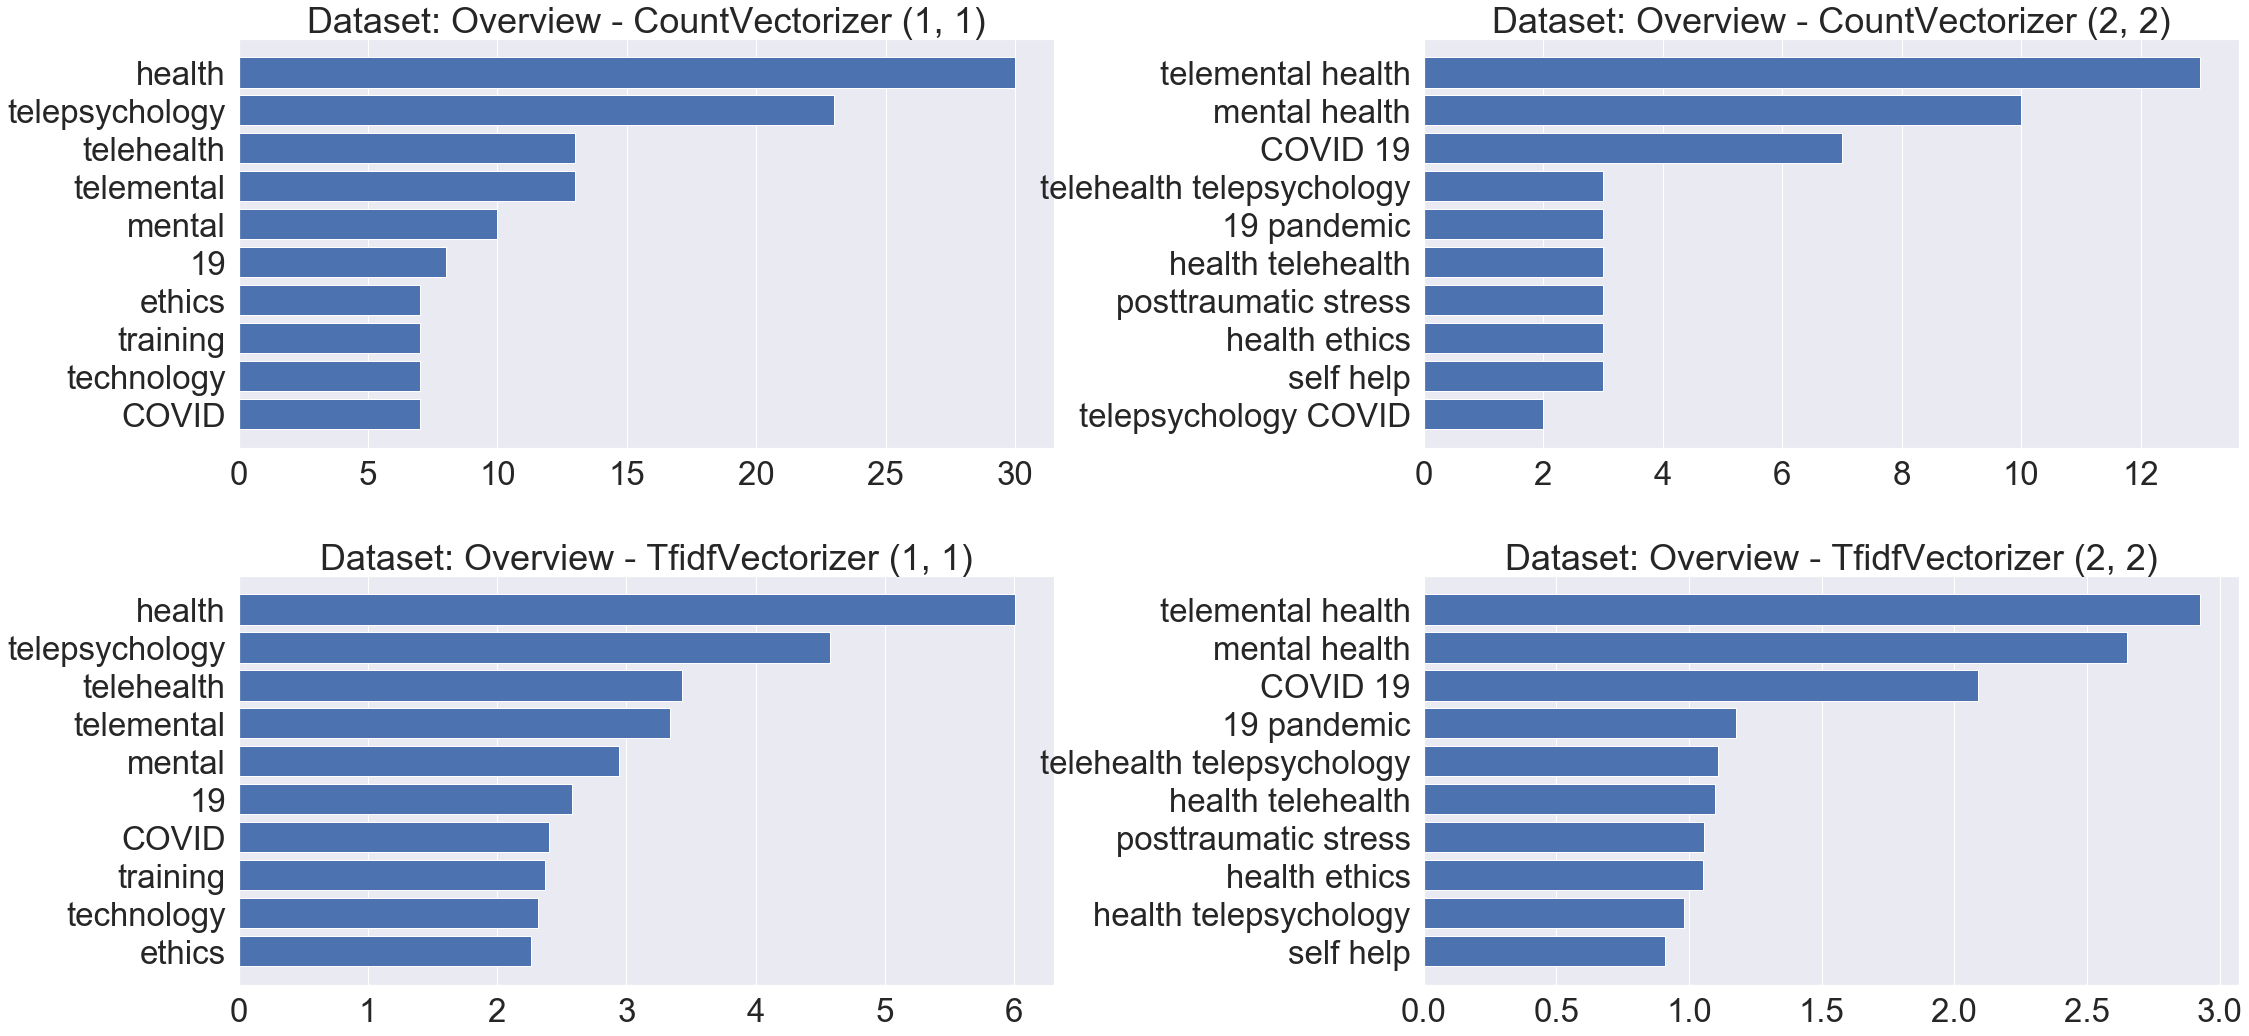

In [23]:
parsed_words = df_overview["Parsed_Keywords"].to_list()
countplots(parsed_words,"Overview",[CountVectorizer,TfidfVectorizer],cols=2)

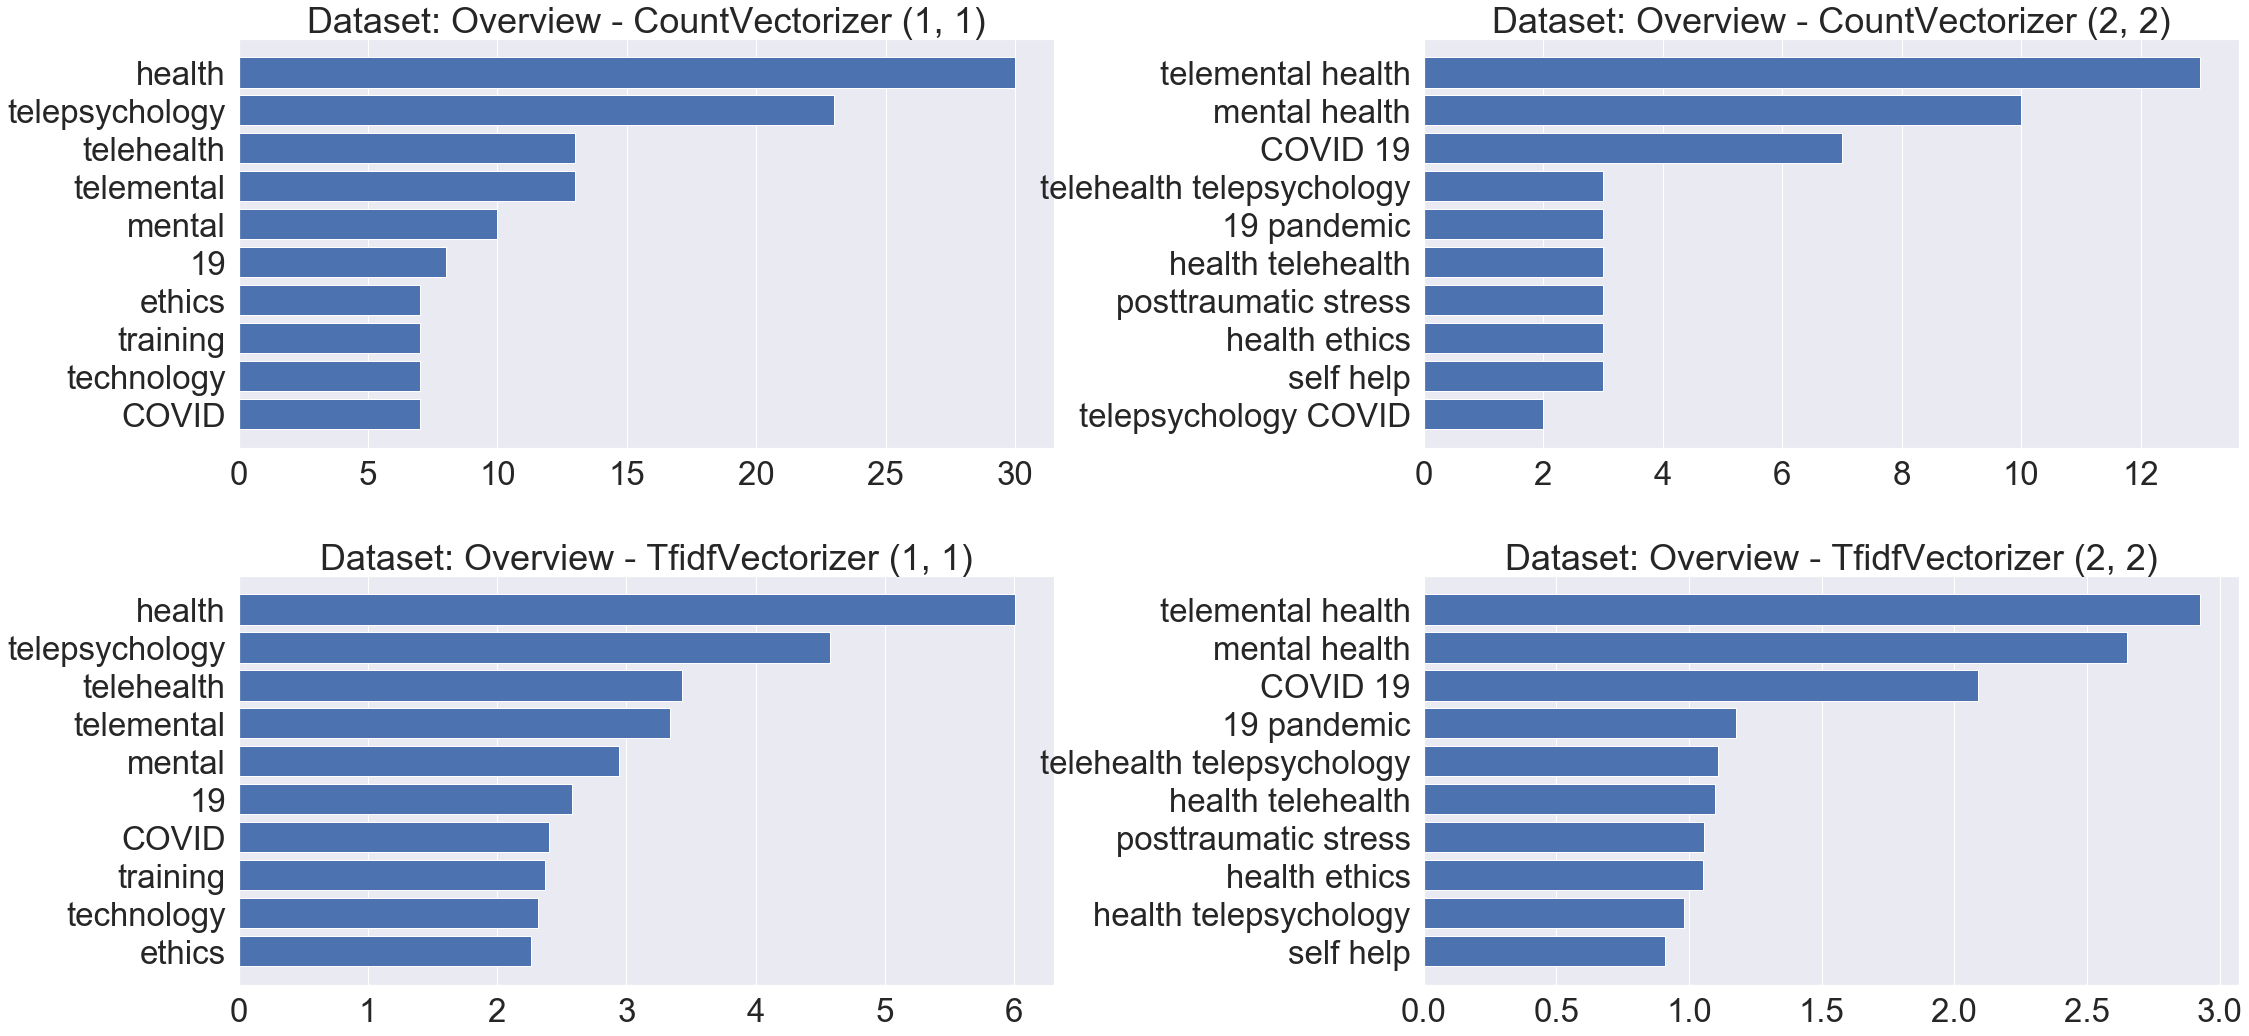

In [24]:
parsed_words = df_overview["Parsed_Keywords"].to_list()
countplots(parsed_words,"Overview",[CountVectorizer,TfidfVectorizer],cols=2)

## Keyword Extraction Gensim

In [25]:
import gensim
from gensim.summarization import keywords, mz_keywords
full_text = ''
for i in df_overview["LongForm_Clean_Content_Lemma"]:
  full_text = full_text + i
Overall_Keywords = keywords(full_text, words = 10, scores = True) #Returns list of keywords and their relevance scores
# print(Overall_Keywords)
Overall1 = pd.DataFrame(Overall_Keywords)
Overall1.head()

,0,1
0,timing,0.404644
1,timely,0.404644
2,time locate,0.314682
3,location,0.224720
4,provider,0.162794


In [26]:
Overall2 = pd.DataFrame(mz_keywords(full_text, scores=True, split = True, weighted=False, threshold=1.0))
Overall2.head()

/Users/adamgoldstein/opt/anaconda3/lib/python3.7/site-packages/gensim/summarization/mz_entropy.py:65: RuntimeWarning: divide by zero encountered in log2
  log_p = np.log2(p)
/Users/adamgoldstein/opt/anaconda3/lib/python3.7/site-packages/gensim/summarization/mz_entropy.py:66: RuntimeWarning: invalid value encountered in multiply
  h = np.nan_to_num(p * log_p).sum(axis=0)


,0,1
0,binformation,4.030892
1,tbehavioral,3.770133
2,latinx,3.595109
3,rotation,3.460209
4,father,3.387907


In [27]:
full_text = ''
for i in df_precovid["LongForm_Clean_Content_Lemma"]:
  full_text = full_text + i
Pre_Keywords = keywords(full_text, words = 10, scores = True) #Returns list of keywords and their relevance scores
# print(Overall_Keywords)
pre1 = pd.DataFrame(Pre_Keywords)
pre2 = pd.DataFrame(mz_keywords(full_text,blocksize = 25, scores=True, split = True, weighted=False, threshold=.5))

/Users/adamgoldstein/opt/anaconda3/lib/python3.7/site-packages/gensim/summarization/mz_entropy.py:65: RuntimeWarning: divide by zero encountered in log2
  log_p = np.log2(p)
/Users/adamgoldstein/opt/anaconda3/lib/python3.7/site-packages/gensim/summarization/mz_entropy.py:66: RuntimeWarning: invalid value encountered in multiply
  h = np.nan_to_num(p * log_p).sum(axis=0)


In [28]:
full_text = ''
for i in df_covid["LongForm_Clean_Content_Lemma"]:
  full_text = full_text + i
Covid_Keywords = keywords(full_text, words = 10, scores = True) #Returns list of keywords and their relevance scores
# print(Overall_Keywords)
covid1 = pd.DataFrame(Covid_Keywords)
covid2 = pd.DataFrame(mz_keywords(full_text, blocksize = 25, scores=True, split = True, weighted=False, threshold=.5))

In [29]:
covid2[0][:10].tolist

<bound method IndexOpsMixin.tolist of 0            aacap
1           angold
2          medalia
3             blue
4    admissibility
5          dreyfus
6        emphysema
7         lexicomp
8         marriage
9        mehrabian
Name: 0, dtype: object>

In [30]:
data = {'Overall Keywords': Overall1[0][:10].to_list(), 'Overall MZ Keywords':Overall2[0][:10].to_list(), 'Prepandemic Keywords':pre1[0][:10].to_list(), 'Prepandemic MZ Keywords':pre2[0][:10].to_list(), 'Covid Keywords':covid1[0][:10].to_list(), 'Covid MZ Keywords': covid2[0][:10].tolist()}
data.keys()

dict_keys(['Overall Keywords', 'Overall MZ Keywords', 'Prepandemic Keywords', 'Prepandemic MZ Keywords', 'Covid Keywords', 'Covid MZ Keywords'])

In [31]:
merged_df = pd.DataFrame(data=data)
merged_df

,Overall Keywords,Overall MZ Keywords,Prepandemic Keywords,Prepandemic MZ Keywords,Covid Keywords,Covid MZ Keywords
0,timing,binformation,timely,postbaseline,timing,aacap
1,timely,tbehavioral,timing,solving,timely,angold
2,time locate,latinx,time locate,cullum,time locate,medalia
3,location,rotation,location,compact,location,blue
4,provider,father,researcher,statewide,provider,admissibility
5,providers,mbc,researchers,agrarian,providers,dreyfus
6,provide,telesupervision,provide,assisted,provide,emphysema
7,providence,technologys,provider,attendant,research,lexicomp
8,researcher,respiratime,providers,curse,researcher,marriage
9,researchers,ssf,providence,desensitization,researchers,mehrabian


In [32]:
merged_df.to_csv('./Keywords.csv')

# Keyword Extraction NLTK Rake

In [33]:
!pip install rake-nltk

In [34]:
from rake_nltk import Rake

keyword_corpus = " ".join(df_overview["LongForm_Clean_Content_Lemma"].str.replace("et al",""))

r_extraction = Rake()

r_extraction.extract_keywords_from_text(keyword_corpus)

In [35]:
r_extraction.get_ranked_phrases()[:10]

['treat various disorder bee 2008 postel de haan de jong 2008 include posttraumatic stress disorder germain marchand bouchard drouin guay 2009 depression sloan gallagher feinstein lee pruneau 2011 anxiety ruskin 2004 substance use frueh henderson myrick 2005 chronic pain macea gajos calil fregni 2010',
 'largely positive adler pritchett kauth nadorff 2014 baird whitney caedo 2018 brooks manson bair dailey shore 2012 cunningham connors lever stephan 2013 levy strachan 2013 mitchell maclaren mortimes locate withinn carachi 2009 moreau 2018 whitten kuwahara 2004 wynn bergvik pettersen fossum 2012',
 'neuropsychological testing bouchard 2004 cullum hynan grosch parikh weiner 2014 cullum weiner gehrmasculine gendern hynan 2006 gehrmasculine gender shah miles kuna godleski 2016 gros yoder tuerk lozano acierno 2011 hilty 2013 morland 2014 morland hynes mackintimes locate withinsh resick chard 2011the veteran ’',
 'autism goodwin mazefsky ioannidis erdogmus siegel 2019 hollis falconer martin w